<a href="https://colab.research.google.com/github/xharles2994/Tensorflow_models/blob/main/Multitaks_Recommendation_System_on_game_dataset_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multitaks_Recommendation_System_on_game_dataset_CV.ipynb

##problem Statement:
The Steam Store, a popular digital distribution platform for video games, provides users with a vast selection of games to choose from. However, with such a large number of games available, it becomes challenging for users to discover games that align with their preferences and interests. The existing recommendation system on the Steam Store lacks the ability to effectively combine retrieval and ranking techniques to provide personalized game recommendations. Therefore, there is a need to develop a combined retrieval and ranking system for game recommendations on the Steam Store using a two-tower model with TensorFlow Recommenders.

##Objective:
The objective of this project is to design and implement a game recommendation system for the Steam Store that leverages the power of TensorFlow Recommenders and utilizes a two-tower model. The system should address the limitations of the existing recommendation system and provide users with personalized and relevant game recommendations based on their preferences. The specific objectives of the project are as follows:

1. Data Preparation: Collect and preprocess the relevant data, including user preferences, game metadata, and historical interactions, to create a suitable dataset for training and evaluation.

2. Model Development: Build a combined retrieval and ranking model using a two-tower architecture with TensorFlow Recommenders. The two-tower model should incorporate both user preferences and game features to generate personalized recommendations.

3. Training and Evaluation: Train the two-tower model using the prepared dataset and evaluate its performance using appropriate evaluation metrics. Fine-tune the model to optimize recommendation accuracy and relevance.

4. Integration with Steam Store: Integrate the developed recommendation system with the Steam Store platform, enabling users to receive personalized game recommendations based on their preferences.

5. User Interface: Design and develop a user-friendly interface that allows users to provide feedback on recommended games, explore additional recommendations, and customize their preferences.

6. Performance Optimization: Optimize the recommendation system for scalability and efficiency to handle a large number of users and games, ensuring real-time recommendations with minimal latency.

By achieving these objectives, the combined retrieval and ranking system utilizing a two-tower model will enhance the game discovery experience on the Steam Store, providing users with tailored recommendations that match their interests and preferences.

###Imports
Let's include our imports here. Here we import our tensorflow and python libaries to be called in the project

In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann

In [ ]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
import tensorflow_recommenders as tfrs

#About the dataset
https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam

##Context
The dataset contains cleaned and preprocessed 10M+ samples of user recommendations (reviews) from a Steam Store - a leading online platform for purchasing and downloading video games, DLC, and other gaming-related content. Additionally, it contains detailed information about games and add-ons.
The dataset consists of three main entities:

##Content
Games.csv - a table of games (or add-ons) information on ratings, pricing in US dollars $, release date, etc. A piece of extra non-tabular details on games, such as descriptions and tags, is in a metadata file;

Users.csv - a table of user profiles' public information: the number of purchased products and reviews published;

Recommendations.csv - a table of user reviews: whether the user recommends a product. The table represents a many-many relation between a game entity and a user entity.



#Acknowledgement - The dataset was collected from Steam Official Store. All rights on the dataset thumbnail image belong to the Valve Corporation.

#Preparing the dataset
Let's first have a look at the data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# load the recommenders data

columns = ['app_id', 'helpful', 'funny', 'date', 'is_recommended', 'user_id', 'review_id']
ratings = pd.read_csv('/content/drive/MyDrive/PORTFOLIO/Dataset/Game-recommendation_Retrieval/recommendations.csv')
ratings.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,19954,0
1,304390,4,0,2017-02-17,False,11.5,1098,1
2,1085660,2,0,2019-11-17,True,336.5,91207,2
3,703080,0,0,2022-09-23,True,27.4,93054,3
4,526870,0,0,2021-01-10,True,7.9,9106,4


In [ ]:
#Code will convert each column
# Read the CSV file
df = pd.read_csv('/content/drive/MyDrive/PORTFOLIO/Dataset/Game-recommendation_Retrieval/games.csv')

# Define a dictionary to map rating strings to integers
rating_map = {
    'Overwhelmingly Negative': 0,
    'Mostly Negative': 1,
    'Very Negative': 2,
    'Negative': 3,
    'Mixed': 4,
    'Positive': 5,
    'Very Positive': 6,
    'Mostly Positive': 7,
    'Overwhelmingly Positive': 8
}

# Create a new column 'ranking' mapped from 'rating'
df['ranking'] = df['rating'].map(rating_map)

# Write the new dataframe to CSV
df.to_csv('games.csv', index=False)

In [ ]:
games = pd.read_csv('games.csv')
games = games[['app_id', 'title', 'ranking']]
games.head()

,app_id,title,ranking
0,10090,Call of Duty: World at War,6
1,13500,Prince of Persia: Warrior Within™,6
2,22364,BRINK: Agents of Change,5
3,113020,Monaco: What's Yours Is Mine,6
4,226560,Escape Dead Island,4


In [ ]:
# join the ratings with the games

ratings = pd.merge(ratings, games, on='app_id')


# keep only the user id and the games title columns

ratings = ratings[['title', 'user_id', 'ranking']].reset_index(drop=True)

ratings

,title,user_id,ranking
0,Dwarf Fortress,19954,8
1,Dwarf Fortress,4993590,8
2,Dwarf Fortress,4452487,8
3,Dwarf Fortress,3602361,8
4,Dwarf Fortress,5279412,8
...,...,...,...
10072265,Paragon: The Overprime,373561,4
10072266,Paragon: The Overprime,2165144,4
10072267,Paragon: The Overprime,4388597,4
10072268,Paragon: The Overprime,705328,4


In [ ]:
# save to a csv file

ratings.to_csv('ratings.csv', index=False)
games.to_csv('games.csv', index=False)

In [ ]:
from typing import Dict, Text
# read the csv files as pandas data frames
ratings_df = pd.read_csv('ratings.csv')
games_df = pd.read_csv('games.csv')

We now convert our Panda Dataframe into Tensorflow dataset

In [ ]:
# convert them to tf datasets
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df))
games = tf.data.Dataset.from_tensor_slices(dict(games_df))

In [ ]:
# get the first rows of the games dataset in tensorflows records
for g in games.take(5):
  print(g)

{'app_id': <tf.Tensor: shape=(), dtype=int64, numpy=10090>, 'title': <tf.Tensor: shape=(), dtype=string, numpy=b'Call of Duty: World at War'>, 'ranking': <tf.Tensor: shape=(), dtype=int64, numpy=6>}
{'app_id': <tf.Tensor: shape=(), dtype=int64, numpy=13500>, 'title': <tf.Tensor: shape=(), dtype=string, numpy=b'Prince of Persia: Warrior Within\xe2\x84\xa2'>, 'ranking': <tf.Tensor: shape=(), dtype=int64, numpy=6>}
{'app_id': <tf.Tensor: shape=(), dtype=int64, numpy=22364>, 'title': <tf.Tensor: shape=(), dtype=string, numpy=b'BRINK: Agents of Change'>, 'ranking': <tf.Tensor: shape=(), dtype=int64, numpy=5>}
{'app_id': <tf.Tensor: shape=(), dtype=int64, numpy=113020>, 'title': <tf.Tensor: shape=(), dtype=string, numpy=b"Monaco: What's Yours Is Mine">, 'ranking': <tf.Tensor: shape=(), dtype=int64, numpy=6>}
{'app_id': <tf.Tensor: shape=(), dtype=int64, numpy=226560>, 'title': <tf.Tensor: shape=(), dtype=string, numpy=b'Escape Dead Island'>, 'ranking': <tf.Tensor: shape=(), dtype=int64, nump

In [ ]:
# get the first rows of the ratings/recommendatons dataset in tensorflows records
for r in ratings.take(5):
  print(r)

{'title': <tf.Tensor: shape=(), dtype=string, numpy=b'Dwarf Fortress'>, 'user_id': <tf.Tensor: shape=(), dtype=int64, numpy=19954>, 'ranking': <tf.Tensor: shape=(), dtype=int64, numpy=8>}
{'title': <tf.Tensor: shape=(), dtype=string, numpy=b'Dwarf Fortress'>, 'user_id': <tf.Tensor: shape=(), dtype=int64, numpy=4993590>, 'ranking': <tf.Tensor: shape=(), dtype=int64, numpy=8>}
{'title': <tf.Tensor: shape=(), dtype=string, numpy=b'Dwarf Fortress'>, 'user_id': <tf.Tensor: shape=(), dtype=int64, numpy=4452487>, 'ranking': <tf.Tensor: shape=(), dtype=int64, numpy=8>}
{'title': <tf.Tensor: shape=(), dtype=string, numpy=b'Dwarf Fortress'>, 'user_id': <tf.Tensor: shape=(), dtype=int64, numpy=3602361>, 'ranking': <tf.Tensor: shape=(), dtype=int64, numpy=8>}
{'title': <tf.Tensor: shape=(), dtype=string, numpy=b'Dwarf Fortress'>, 'user_id': <tf.Tensor: shape=(), dtype=int64, numpy=5279412>, 'ranking': <tf.Tensor: shape=(), dtype=int64, numpy=8>}


In this example, we're going to focus on the ratings data. Other tutorials explore how to use the game information data as well to improve the model quality.

We keep only the `user_id`, and `title` fields in the dataset.

In [ ]:
# Select the basic features.
ratings = ratings.map(lambda x: {
    "title": x["title"],
    "user_id": x["user_id"],
    "ranking": x["ranking"],
})
games = games.map(lambda x: x["title"])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


And repeat our preparations for building vocabularies and splitting the data into a train and a test set:

In [ ]:
# Randomly shuffle data and split between train and test.
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

game_titles = games.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_game_titles = np.unique(np.concatenate(list(game_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

## Implementing a model



## A multi-task model

Description:

A multitask recommendation system is a powerful approach that combines multiple tasks within a single framework to improve the accuracy and effectiveness of personalized recommendations. In this system, two key models are employed: a retrieval model and a ranking model. The retrieval model utilizes a two-tower architecture, while the ranking model focuses on generating a ranked list of recommendations. To define the importance of each model task loss, weights are assigned.

The retrieval model,
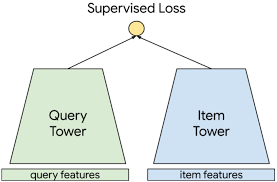
 based on the two-tower architecture, is responsible for retrieving a set of candidate items that are likely to be of interest to the user. It takes into account user preferences and item features to generate embeddings for both users and items. The embeddings capture the latent representations of users and items in a shared space, enabling efficient retrieval of candidate items.

The ranking model takes the retrieved candidate items and applies a ranking algorithm to determine their relative order of importance. This model aims to prioritize the items that are most relevant and appealing to the user. It considers various factors such as user preferences, historical interactions, and item characteristics to assign a ranking score to each candidate item.

To train the multitask recommendation system, a combination of loss functions is employed. The retrieval model loss focuses on optimizing the embeddings and ensuring accurate candidate retrieval. The ranking model loss emphasizes the generation of a high-quality ranked list. The weights assigned to each loss function determine the relative importance given to each task during the training process. By adjusting these weights, the system can prioritize one task over the other based on specific objectives and requirements.

The use of a multitask recommendation system with a two-tower retrieval model and a ranking model offers several benefits. It allows for more accurate and personalized recommendations by leveraging the strengths of both models. The retrieval model efficiently narrows down the set of candidate items, while the ranking model fine-tunes the order to optimize the user experience. The weights assigned to the task losses enable flexibility in defining the importance of each task based on the specific goals of the recommendation system.

Overall, a multitask recommendation system with a two-tower retrieval model and a ranking model, along with the use of task loss weights, provides an effective approach for generating personalized recommendations that align with user preferences and maximize recommendation quality.

In [ ]:
class MovielensModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 32

    # User and movie models.
    self.game_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_game_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_game_titles) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.IntegerLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # A small model to take in user and movie embeddings and predict ratings.
    # We can make this as complicated as we want as long as we output a scalar
    # as our prediction.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=games.batch(128).map(self.game_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["user_id"])
    # And pick out the movie features and pass them into the movie model.
    game_embeddings = self.game_model(features["title"])

    return (
        user_embeddings,
        game_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, game_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("ranking")

    user_embeddings, game_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, game_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)

###Rating-specialized model
Depending on the weights we assign, the model will encode a different balance of the tasks. Let's start with a model that only considers ratings.

In [ ]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=0.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [ ]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [ ]:
model.fit(cached_train, epochs=3)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/3


### Retrieval-specialized model

Let's now try a model that focuses on retrieval only.

In [ ]:
model = MovielensModel(rating_weight=0.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [ ]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [ ]:
model.fit(cached_train, epochs=3)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/3
10/10 [==============================] - 460s 45s/step - root_mean_squared_error: 5.8455 - factorized_top_k/top_1_categorical_accuracy: 0.0555 - factorized_top_k/top_5_categorical_accuracy: 0.1330 - factorized_top_k/top_10_categorical_accuracy: 0.1452 - factorized_top_k/top_50_categorical_accuracy: 0.1746 - factorized_top_k/top_100_categorical_accuracy: 0.1889 - loss: 70369.3253 - regularization_loss: 0.0000e+00 - total_loss: 70369.3253
Epoch 2/3
10/10 [==============================] - 455s 46s/step - root_mean_squared_error: 5.7697 - factorized_top_k/top_1_categorical_accuracy: 0.1302 - factorized_top_k/top_5_categorical_accuracy: 0.8551 - factorized_top_k/top_10_categorical_accuracy: 0.8586 - factorized_top_k/top_50_categorical_accuracy: 0.8656 - factorized_top_k/top_100_categorical_accuracy: 0.8691 - loss: 69022.9737 - regularization_loss: 0.0000e+00 - total_loss: 69022.9737
Epoch 3/3
5/5 [==============================] - 115s 23s/step - root_mean_squared_error: 6.4659 -

## Making predictions on retrieval specialized model

Now that we have the multitask model, we would like to be able to make predictions. We can use the `tfrs.layers.factorized_top_k.BruteForce` layer to do this.

In [ ]:
# Use brute-force search to set up retrieval using the trained representations.
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    games.batch(100).map(lambda title: (title, model.game_model(title))))

# Get some recommendations.
_, titles = index(np.array([19954]))
print(f"Top 10 recommendations for user 19954: {titles[0, :10]}")

Top 10 recommendations for user 19954: [b'Dwarf Fortress' b'President Trump The Way In Uganda' b'Frisky Business'
 b'Ion Assault' b'Monster Maze VR' b'Rolled Out!' b'Myrne: The Quest'
 b'Guns n Zombies' b"Pajama Sam: No Need to Hide When It's Dark Outside"
 b'Z. Year One']


### Joint model

Let's now train a model that assigns positive weights to both tasks.

In [ ]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [ ]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [ ]:
model.fit(cached_train, epochs=3)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/3
10/10 [==============================] - 474s 46s/step - root_mean_squared_error: 4.0085 - factorized_top_k/top_1_categorical_accuracy: 0.0613 - factorized_top_k/top_5_categorical_accuracy: 0.1550 - factorized_top_k/top_10_categorical_accuracy: 0.1670 - factorized_top_k/top_50_categorical_accuracy: 0.1955 - factorized_top_k/top_100_categorical_accuracy: 0.2097 - loss: 70383.3906 - regularization_loss: 0.0000e+00 - total_loss: 70383.3906
Epoch 2/3
10/10 [==============================] - 462s 46s/step - root_mean_squared_error: 1.6126 - factorized_top_k/top_1_categorical_accuracy: 0.1343 - factorized_top_k/top_5_categorical_accuracy: 0.8771 - factorized_top_k/top_10_categorical_accuracy: 0.8798 - factorized_top_k/top_50_categorical_accuracy: 0.8859 - factorized_top_k/top_100_categorical_accuracy: 0.8887 - loss: 68826.9602 - regularization_loss: 0.0000e+00 - total_loss: 68826.9602
Epoch 3/3
5/5 [==============================] - 120s 24s/step - root_mean_squared_error: 0.8996 -

### Making ranking prediction from multitask model

We can use the trained multitask model to get trained user and movie embeddings, as well as the predicted rating:

In [ ]:
trained_games_embeddings, trained_user_embeddings, trained_rating_predictions = model({
      "user_id": np.array([19954]),
      "title": np.array(["Ion Assault"])
  })
print("Predicted rating:")
print(trained_rating_predictions)

Predicted rating:
tf.Tensor([[3.5993714]], shape=(1, 1), dtype=float32)
